# Optimal Filter 1x1 Trigger  and Event Builder


In [3]:
import qetpy as qp
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import pytesdaq.io.hdf5 as h5io
import warnings
from detprocess import OptimumFilterTrigger, EventBuilder, Template, Noise
warnings.filterwarnings('ignore')
import vaex as vx

## Datasets and channels

In [4]:
channels = ['Melange1pc1ch', 'Melange4pc1ch']

# Continuous data path and series with both channels
continuous_data_path = '/sdata1/runs/run28/raw/continuous_I2_D20230630_T193129'
continuous_data_series = 'I2_D20230630_T193742'

## Noise PSD

### Select randoms

In [5]:
noise = Noise(verbose=True)
noise.generate_randoms(continuous_data_path, series=continuous_data_series, 
                       nevents=1000, min_separation_msec=100, ncores=1)

INFO: Found total of 4 raw data file(s) from 1 different series number!
INFO: Found total of 4 files from 1 different series number!
INFO node #1: Acquiring randoms for series I2_D20230630_T193742
INFO: Randoms acquisition done!


INFO: Processing PSD for channel Melange1pc1ch
INFO: 1000 events found in raw data for channel(s) Melange1pc1ch
INFO: Number of events after cuts = 260, efficiency = 26.00%
INFO: Processing PSD for channel Melange4pc1ch
INFO: 1000 events found in raw data for channel(s) Melange4pc1ch
INFO: Number of events after cuts = 496, efficiency = 49.60%


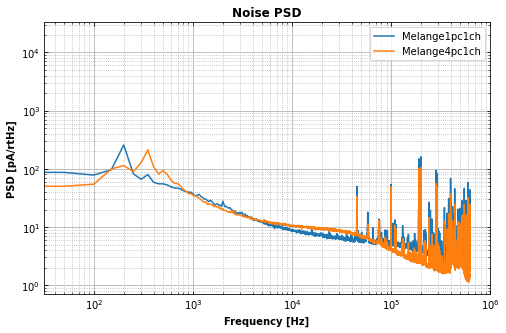

In [6]:
# 20 ms trace length
trace_length_msec = 20
pretrigger_length_msec = 10


# calculate PSD
noise.calc_psd(channels,
               nevents=1000,
               trace_length_msec=trace_length_msec, 
               pretrigger_length_msec=pretrigger_length_msec)

# display
noise.plot_psd(channels, fold=True)

# get values
psd_melange1pc1ch, psd_freq = noise.get_psd('Melange1pc1ch')
psd_melange4pc1ch, psd_freq = noise.get_psd('Melange4pc1ch')
fs = noise.get_sample_rate()

## Template

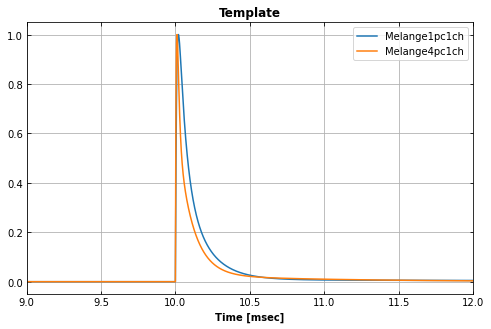

In [7]:
# instantiate template object
template = Template()

# Template Melange 1%1
amplitudes = [1.67e-15, 1.32e-15, 2.39e-17]
fall_times = [44.6e-6, 147.5e-6, 3872.9e-6]
rise_times = [8.79e-6, 8.79e-6, 8.79e-6]

template.create_template_sum_twopoles('Melange1pc1ch', 
                                      amplitudes, rise_times, fall_times,
                                      sample_rate=fs,
                                      trace_length_msec=trace_length_msec,
                                      pretrigger_length_msec=pretrigger_length_msec) 



# Template Melange 4%
amplitudes = [2.8e-15, 2.54e-15, 1.43e-16]
fall_times = [10.0e-6, 99.4e-6, 930.6e-6]
rise_times = [7.00e-6, 7.00e-6, 7.00e-6]

template.create_template_sum_twopoles('Melange4pc1ch', 
                                      amplitudes, rise_times, fall_times,
                                      sample_rate=fs,
                                      trace_length_msec=trace_length_msec,
                                      pretrigger_length_msec=pretrigger_length_msec) 



# get templates array
template_melange1pc1ch, time_array = template.get_template('Melange1pc1ch')
template_melange4pc1ch, time_array = template.get_template('Melange4pc1ch')


# display
template.plot_template(['Melange1pc1ch', 'Melange4pc1ch'], xmin=9, xmax=12)


# conversion to template current

## Continuous Data Traces

In [8]:
# Instantiate raw data reader
h5 = h5io.H5Reader()
h5.set_files(continuous_data_path, series=continuous_data_series)
events, events_info = h5.read_many_events(nevents=7, detector_chans=channels, include_metadata=True, adctoamp=True)


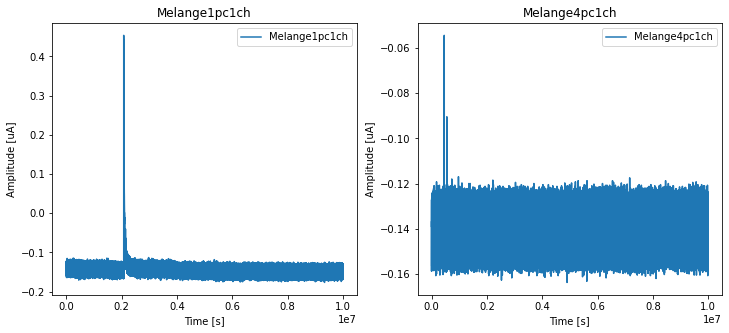

In [11]:
# let's select an event
traces = events[6]
info = events_info[6]
fs = info['sample_rate']
dt = 1/fs
bins = np.asarray(list(range(traces.shape[-1])))*dt*1e6

# display
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
for it in range(2):
    ax[it].plot(bins, traces[it,:]*1e6, label=channels[it])
    ax[it].legend()
    ax[it].set_title(channels[it])
    ax[it].set_xlabel("Time [s]")
    ax[it].set_ylabel("Amplitude [uA]")

## Optimal Filter Trigger

### instantiate OF 

In [12]:
# instantiate
pretrigger_sample = int(pretrigger_length_msec*1e-3*fs)

OF_melange1pc1ch = OptimumFilterTrigger(channels[0], fs,template_melange1pc1ch, 
                                        psd_melange1pc1ch,pretrigger_sample)
OF_melange4pc1ch = OptimumFilterTrigger(channels[1], fs,template_melange4pc1ch, 
                                        psd_melange4pc1ch,pretrigger_sample)


###  Update trace

In [13]:
OF_melange1pc1ch.update_trace(traces[0,:])
OF_melange4pc1ch.update_trace(traces[1,:])

### Display filtered traces

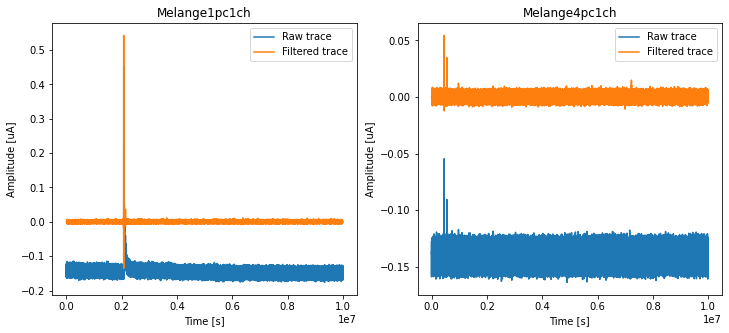

In [14]:
# display
filtered_traces = np.zeros_like(traces)
filtered_traces[0,:] = OF_melange1pc1ch._filtered_trace
filtered_traces[1,:] = OF_melange4pc1ch._filtered_trace



fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
for it in range(2):
    ax[it].plot(bins, traces[it,:]*1e6, label='Raw trace')
    ax[it].plot(bins, filtered_traces[it,:]*1e6, label='Filtered trace')
    ax[it].legend()
    ax[it].set_title(channels[it])
    ax[it].set_xlabel("Time [s]")
    ax[it].set_ylabel("Amplitude [uA]")



### Find triggers

In [15]:
thresh_sigma = 8

# melange 1%
OF_melange1pc1ch.find_triggers(thresh_sigma, pileup_window_msec=1)
trigger_df_melange1pc1ch = OF_melange1pc1ch.get_trigger_data_df()

# melange 4%
OF_melange4pc1ch.find_triggers(thresh_sigma, pileup_window_msec=1)
trigger_df_melange4pc1ch = OF_melange4pc1ch.get_trigger_data_df()



In [16]:
trigger_df_melange1pc1ch

#,trigger_amplitude,trigger_time,trigger_index,trigger_pileup_window,trigger_threshold_sigma,trigger_type,trigger_amplitude_Melange1pc1ch,trigger_time_Melange1pc1ch,trigger_index_Melange1pc1ch,trigger_pileup_window_Melange1pc1ch,trigger_threshold_sigma_Melange1pc1ch,trigger_type_Melange1pc1ch,trigger_channel
0,5.42589e-07,2.0756,2594503,1250,8,4,5.42589e-07,2.0756,2594503,1250,8,4,Melange1pc1ch
1,1.48377e-08,2.08331,2604138,1250,8,4,1.48377e-08,2.08331,2604138,1250,8,4,Melange1pc1ch
2,3.73137e-08,2.13947,2674335,1250,8,4,3.73137e-08,2.13947,2674335,1250,8,4,Melange1pc1ch


In [17]:
trigger_df_melange4pc1ch

#,trigger_amplitude,trigger_time,trigger_index,trigger_pileup_window,trigger_threshold_sigma,trigger_type,trigger_amplitude_Melange4pc1ch,trigger_time_Melange4pc1ch,trigger_index_Melange4pc1ch,trigger_pileup_window_Melange4pc1ch,trigger_threshold_sigma_Melange4pc1ch,trigger_type_Melange4pc1ch,trigger_channel
0,5.44149e-08,0.459959,574949,1250,8,4,5.44149e-08,0.459959,574949,1250,8,4,Melange4pc1ch
1,3.46699e-08,0.55399,692488,1250,8,4,3.46699e-08,0.55399,692488,1250,8,4,Melange4pc1ch
2,1.48348e-08,7.22519,9031487,1250,8,4,1.48348e-08,7.22519,9031487,1250,8,4,Melange4pc1ch


## Event Builder

In [18]:
builder = EventBuilder()
builder.add_trigger_data('Melange1pc1ch', trigger_df_melange1pc1ch)
builder.add_trigger_data('Melange14c1ch', trigger_df_melange4pc1ch)

# merge triggers
builder.build_event(info, coincident_window_msec=0.01)

# get event data
df = builder.get_event_df()

In [19]:
df

#,trigger_amplitude,trigger_time,trigger_index,trigger_pileup_window,trigger_threshold_sigma,trigger_type,trigger_amplitude_Melange1pc1ch,trigger_time_Melange1pc1ch,trigger_index_Melange1pc1ch,trigger_pileup_window_Melange1pc1ch,trigger_threshold_sigma_Melange1pc1ch,trigger_type_Melange1pc1ch,trigger_channel,trigger_amplitude_Melange4pc1ch,trigger_time_Melange4pc1ch,trigger_index_Melange4pc1ch,trigger_pileup_window_Melange4pc1ch,trigger_threshold_sigma_Melange4pc1ch,trigger_type_Melange4pc1ch,series_number,event_number,dump_number,series_start_time,group_start_time,fridge_run_start_time,fridge_run_number,data_type,group_name,event_time,trigger_prod_id
0,5.44149e-08,0.459959,574949,1250,8,4,nan,nan,nan,nan,nan,nan,Melange4pc1ch,5.44149e-08,0.459959,574949,1250,8,4,220230630193742,100007,1,nan,nan,nan,28,1,continuous_I2_D20230630_T193129,1688179134,1
1,3.46699e-08,0.55399,692488,1250,8,4,nan,nan,nan,nan,nan,nan,Melange4pc1ch,3.46699e-08,0.55399,692488,1250,8,4,220230630193742,100007,1,nan,nan,nan,28,1,continuous_I2_D20230630_T193129,1688179135,2
2,5.42589e-07,2.0756,2594503,1250,8,4,5.42589e-07,2.0756,2.5945e+06,1250,8,4,Melange1pc1ch,nan,nan,nan,nan,nan,nan,220230630193742,100007,1,nan,nan,nan,28,1,continuous_I2_D20230630_T193129,1688179136,3
3,1.48377e-08,2.08331,2604138,1250,8,4,1.48377e-08,2.08331,2.60414e+06,1250,8,4,Melange1pc1ch,nan,nan,nan,nan,nan,nan,220230630193742,100007,1,nan,nan,nan,28,1,continuous_I2_D20230630_T193129,1688179136,4
4,3.73137e-08,2.13947,2674335,1250,8,4,3.73137e-08,2.13947,2.67434e+06,1250,8,4,Melange1pc1ch,nan,nan,nan,nan,nan,nan,220230630193742,100007,1,nan,nan,nan,28,1,continuous_I2_D20230630_T193129,1688179136,5
5,1.48348e-08,7.22519,9031487,1250,8,4,nan,nan,nan,nan,nan,nan,Melange4pc1ch,1.48348e-08,7.22519,9.03149e+06,1250,8,4,220230630193742,100007,1,nan,nan,nan,28,1,continuous_I2_D20230630_T193129,1688179141,6
